In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import dtale

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

In [9]:
df_leagues = pd.read_csv('../data/csv/Leagues.csv', index_col=0)

#df_leagues.drop(['date', 'league', 'matchweek', 'home_team_id', 'away_team_id', 'home_team', 'away_team', 'home_manager', 'away_manager'], axis=1, inplace=True)
df_leagues.drop(['date', 'league', 'matchweek', 'home_team_id', 'away_team_id', 'home_team', 'away_team'], axis=1, inplace=True)
print(f'Nb NaN: {df_leagues.isna().sum().sum()}')

df_leagues['home_team_form'] = df_leagues['home_team_form'].fillna('')
df_leagues['home_team_home_form'] = df_leagues['home_team_home_form'].fillna('')
df_leagues['home_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['home_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['home_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['home_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)
df_leagues['away_team_form'] = df_leagues['away_team_form'].fillna('')
df_leagues['away_team_away_form'] = df_leagues['away_team_away_form'].fillna('')
df_leagues['away_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['away_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['away_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['away_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)

print(f'Nb NaN: {df_leagues.isna().sum().sum()}')
df_leagues.head()

Nb NaN: 2960
Nb NaN: 0


,home_manager,home_formation,home_goals,home_xg,away_xg,away_goals,away_manager,away_formation,home_team_form,home_team_league_pos,...,away_team_form,away_team_league_pos,away_team_points_diff,away_team_away_form,away_team_away_league_pos,away_team_away_points_diff,away_team_average_goals_form,away_team_average_xg_form,away_team_average_goals_form_against,away_team_average_xg_form_against
0,Erik ten Hag,4-2-3-1,1,2.4,0.4,0,Marco Silva,4-2-3-1,,1.0,...,,1.0,0,,1.0,0,0.000000,0.000000,0.000000,0.000000
1,Steve Cooper,4-2-3-1,1,0.8,1.7,3,Nuno Espírito Santo,4-2-3-1,DDLWW,14.0,...,WDLDW,7.0,-2,WDD,2.0,2,1.000000,0.633333,1.000000,1.533333
2,Steve Cooper,4-2-3-1,1,1.0,1.2,1,Ange Postecoglou,4-3-3,,1.0,...,,1.0,0,,1.0,0,0.000000,0.000000,0.000000,0.000000
3,Marco Silva,4-2-3-1,2,1.3,0.6,1,Thomas Frank,4-2-3-1,WWLLD,10.0,...,LDWLW,8.0,1,LLL,19.0,0,1.666667,1.833333,1.666667,1.300000
4,Nuno Espírito Santo,4-2-3-1,1,1.7,1.0,0,Oliver Glasner,3-1-4-2,DWDLD,9.0,...,DDDLL,18.0,-1,LDL,17.0,-2,0.666667,1.033333,1.000000,1.066667


In [16]:
def get_train_test_split(df: pd.DataFrame, label_name:str = 'home_goals') -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    y_train = df_train[f'{label_name}']
    y_test = df_test[f'{label_name}']

    del df_train[f'{label_name}']
    del df_test[f'{label_name}']
    
    return df_train, df_test, y_train, y_test


def get_X_train_test(df_train:pd.DataFrame, df_test:pd.DataFrame):
    dict_vectorizer = DictVectorizer(sparse=False)
    train_serie_dict = df_train.to_dict(orient='records')
    test_serie_dict = df_test.to_dict(orient='records')

    X_train = dict_vectorizer.fit_transform(train_serie_dict)
    X_test = dict_vectorizer.transform(test_serie_dict)
    
    return X_train, X_test, dict_vectorizer


### Predict Home

In [17]:
df_train_home, df_test_home, y_train_home, y_test_home = get_train_test_split(df_leagues, 'home_goals')
X_train_home, X_test_home, home_dict_vectorizer = get_X_train_test(df_train_home, df_test_home)

y_train_home_no_goal = (y_train_home == 0).astype(int)
y_train_home_one_goal = (y_train_home >= 1).astype(int)
y_train_home_two_goal = (y_train_home >= 2).astype(int)
y_train_home_three_goal = (y_train_home >= 3).astype(int)

y_test_home_no_goal = (y_test_home == 0).astype(int)
y_test_home_one_goal = (y_test_home >= 1).astype(int)
y_test_home_two_goal = (y_test_home >= 2).astype(int)
y_test_home_three_goal = (y_test_home >= 3).astype(int)

y_train_home_combined = np.column_stack([y_train_home_no_goal, y_train_home_one_goal, y_train_home_two_goal, y_train_home_three_goal])
y_test_home_combined = np.column_stack([y_test_home_no_goal, y_test_home_one_goal, y_test_home_two_goal, y_test_home_three_goal])

h_model = MultiOutputClassifier(XGBClassifier(random_state=42))

param_grid = {
    "estimator__max_depth": range(5,60, 5),
    "estimator__learning_rate": [0.01, 0.1],
    "estimator__n_estimators": [200],
    "estimator__subsample": [0.8],
    "estimator__colsample_bytree": [0.8],
}

grid_search = GridSearchCV(
    estimator = h_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_home, y_train_home_combined)


print('---------------------------------------------------------------------------')
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score :", grid_search.best_score_)

home_model = grid_search.best_estimator_

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.6s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.7s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.7s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.7s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.7s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator_

In [18]:
y_pred_home = home_model.predict(X_test_home)

accuracy_zero = accuracy_score(y_test_home_no_goal, y_pred_home[:,0])
accuracy_one = accuracy_score(y_test_home_one_goal, y_pred_home[:,1])
accuracy_two = accuracy_score(y_test_home_two_goal, y_pred_home[:,2])
accuracy_three = accuracy_score(y_test_home_three_goal, y_pred_home[:,3])

print(f'Accuracy: 0 Goal -> {accuracy_zero} | 1 Goals -> {accuracy_one} | 2 Goals -> {accuracy_two} | 3 Goals -> {accuracy_three}')

Accuracy: 0 Goal -> 0.774798927613941 | 1 Goals -> 0.774798927613941 | 2 Goals -> 0.7453083109919572 | 3 Goals -> 0.8203753351206434


### Predict Away

In [19]:
#Predict away goals
df_train_away, df_test_away, y_train_away, y_test_away = get_train_test_split(df_leagues, 'away_goals')
X_train_away, X_test_away, away_dict_vectorizer = get_X_train_test(df_train_away, df_test_away)

y_train_away_no_goal = (y_train_away == 0).astype(int)
y_train_away_one_goal = (y_train_away >= 1).astype(int)
y_train_away_two_goal = (y_train_away >= 2).astype(int)
y_train_away_three_goal = (y_train_away >= 3).astype(int)

y_test_away_no_goal = (y_test_away == 0).astype(int)
y_test_away_one_goal = (y_test_away >= 1).astype(int)
y_test_away_two_goal = (y_test_away >= 2).astype(int)
y_test_away_three_goal = (y_test_away >= 3).astype(int)

y_train_away_combined = np.column_stack([y_train_away_no_goal, y_train_away_one_goal, y_train_away_two_goal, y_train_away_three_goal])
y_test_away_combined = np.column_stack([y_test_away_no_goal, y_test_away_one_goal, y_test_away_two_goal, y_test_away_three_goal])

a_model = MultiOutputClassifier(XGBClassifier(random_state=42))

param_grid = {
    "estimator__max_depth": range(5,60, 5),
    "estimator__learning_rate": [0.01, 0.1],
    "estimator__n_estimators": [200],
    "estimator__subsample": [0.8],
    "estimator__colsample_bytree": [0.8],
}

grid_search = GridSearchCV(
    estimator = a_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_away, y_train_away_combined)


print('---------------------------------------------------------------------------')
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score :", grid_search.best_score_)

away_model = grid_search.best_estimator_

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.3s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.3s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.3s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.4s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.5s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator_

In [20]:
y_pred_away = away_model.predict(X_test_away)

accuracy_zero = accuracy_score(y_test_away_no_goal, y_pred_away[:,0])
accuracy_one = accuracy_score(y_test_away_one_goal, y_pred_away[:,1])
accuracy_two = accuracy_score(y_test_away_two_goal, y_pred_away[:,2])
accuracy_three = accuracy_score(y_test_away_three_goal, y_pred_away[:,3])

print(f'Accuracy: 0 Goal -> {accuracy_zero} | 1 Goals -> {accuracy_one} | 2 Goals -> {accuracy_two} | 3 Goals -> {accuracy_three}')

Accuracy: 0 Goal -> 0.7292225201072386 | 1 Goals -> 0.7292225201072386 | 2 Goals -> 0.7520107238605898 | 3 Goals -> 0.8833780160857909


### Predict Score

In [ ]:
X_full_home = np.concatenate([X_train_home, X_test_home], axis=0)

y_pred_home = home_model.predict(X_full_home)
y_pred_home_goals = [
    (np.where(np.array(arr) == 1)[0][-1].item() if 1 in arr else 0) 
    for arr in y_pred_home
]

X_full_away = np.concatenate([X_train_away, X_test_away], axis=0)
y_pred_away = away_model.predict(X_full_away)
y_pred_away_goals = [
    (np.where(np.array(arr) == 1)[0][-1].item() if 1 in arr else 0) 
    for arr in y_pred_away
]

In [28]:
df_leagues_scores = df_leagues.copy()
df_leagues_scores['result'] = [0 if x == 0 else 1 if x > 0 else 2 for x in df_leagues_scores['home_goals'] - df_leagues_scores['away_goals']]
df_leagues_scores['home_goals'] = y_pred_home_goals
df_leagues_scores['away_goals'] = y_pred_away_goals
df_train_result, df_test_result, y_train_result, y_test_result = get_train_test_split(df_leagues_scores, 'result')

X_train_result, X_test_result, score_dict_vectorizer = get_X_train_test(df_train_result, df_test_result)

r_model = xgb.XGBClassifier(random_state=42)

r_param_grid = {
    "max_depth": range(5,45, 5),
    "learning_rate": [0.01, 0.1],
    "n_estimators": [150, 200],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
}

r_grid_search = GridSearchCV(
    estimator = r_model,
    param_grid=r_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

r_grid_search.fit(X_train_result, y_train_result)

print('---------------------------------------------------------------------------')
print("Meilleurs hyperparamètres :", r_grid_search.best_params_)
print("Meilleur score :", r_grid_search.best_score_)

result_model = r_grid_search.best_estimator_

print('---------------------------------------------------------------------------')
print('Meilleurs hyperparamètres : colsample_bytree: 0.8, learning_rate: 0.1, max_depth: 35, n_estimators: 150, subsample: 0.8}')
print('Meilleur score : 0.6510230121524849')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   3.0s


KeyboardInterrupt: 

In [ ]:
y_pred_result = result_model.predict(X_test_result)
accuracy_result = accuracy_score(y_test_result, y_pred_result)

print(f'Accuracy: {accuracy_result}')
print('Accuracy: 0.6514745308310992')

Accuracy: 0.6514745308310992
Accuracy: 0.6514745308310992


Accuracy: 0.6514745308310992
Accuracy: 0.6635388739946381


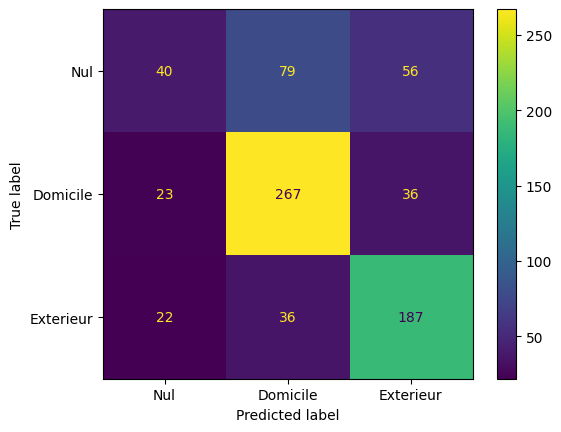

In [ ]:
y_proba_result = result_model.predict_proba(X_test_result)
y_pred_result = [1 if x[1] > 0.37 else 2 if x[2] > 0.37 else 0 for x in y_proba_result]
   
print(f'Accuracy: {accuracy_result}')
print('Accuracy: 0.6635388739946381')
    
cm = confusion_matrix(y_test_result, y_pred_result)
ConfusionMatrixDisplay(cm, display_labels=['Nul', 'Domicile', 'Exterieur']).plot()

### Test

In [ ]:
df_all_leagues = pd.read_csv('../data/csv/Leagues.csv', index_col=0)

def get_last_game_mu():
    df_premier_leagues = df_all_leagues[df_all_leagues['league'].str.contains('Premier League')]
    df_mu_last_game = df_premier_leagues[
        (df_premier_leagues['home_team'].str.contains('Manchester United')) & 
        (df_premier_leagues['away_team'].str.contains('Leicester'))].copy()
    df_mu_last_game = df_mu_last_game[df_mu_last_game['date'].str.contains('2024')].copy()
    #df_mu_last_game['date'] = pd.to_datetime(df_mu_last_game['date'], format='%A %B %d, %Y')
    #df_mu_last_game = df_mu_last_game.sort_values('date', ascending=False).head(1)
    
    return df_mu_last_game

df_mu_last_game = get_last_game_mu()
df_mu_last_game.drop(['league', 'matchweek', 'home_team_id', 'away_team_id', 'home_team', 'away_team'], axis=1, inplace=True)

X_home_goal = home_dict_vectorizer.transform(df_mu_last_game.copy().to_dict(orient='records'))
X_away_goal = away_dict_vectorizer.transform(df_mu_last_game.copy().to_dict(orient='records'))
X_score = score_dict_vectorizer.transform(df_mu_last_game.copy().to_dict(orient='records'))

mu_home_goals = home_model.predict(X_home_goal)
mu_away_goals = away_model.predict(X_away_goal)
mu_result = result_model.predict(X_score)

#df_leagues['result'] = [0 if x == 0 else 1 if x > 0 else 2 for x in df_leagues['home_goals'] - df_leagues['away_goals']]
#df_leagues['home_goals'] = y_pred_home_goals
#df_leagues['away_goals'] = y_pred_away_goals

df_mu_last_game = get_last_game_mu()
print(f'Manchester United vs {df_mu_last_game["away_team"].values[0]} -> {mu_home_goals} - {mu_away_goals} | {mu_result} | {df_mu_last_game["home_goals"].values[0]} - {df_mu_last_game["away_goals"].values[0]}')

df_mu_last_game

Manchester United vs Leicester City -> [[0 1 0 0]] - [[0 1 0 0]] | [1] | 3 - 0


,date,league,matchweek,home_team_id,home_team,home_manager,home_formation,home_goals,home_xg,away_xg,...,away_team_form,away_team_league_pos,away_team_points_diff,away_team_away_form,away_team_away_league_pos,away_team_away_points_diff,away_team_average_goals_form,away_team_average_xg_form,away_team_average_goals_form_against,away_team_average_xg_form_against
88,"Sunday November 10, 2024",Premier League,11,19538871,Manchester United,Ruud van Nistelrooy,4-2-3-1,3,0.8,0.6,...,LWWLD,15.0,4,LWD,10.0,-1,2.0,1.633333,2.333333,2.5
